In [1]:
import pandas as pd
import numpy as np

from pylab import rcParams

import datetime
from datetime import datetime, date

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# считываем данные из файла
data = pd.read_csv('./data.csv', sep = ';')

In [3]:
data.head()

,REPORTDATE,VALUE
0,30.12.2013,3457625638
1,31.12.2013,3417092149
2,01.01.2014,3417092149
3,02.01.2014,3417092149
4,03.01.2014,3417092149


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


In [5]:
type(data.index)

pandas.core.indexes.range.RangeIndex

### __Приведение типов__

Так как я работаю с временным рядом, то необходимо сначала преобразовать дату из типф object в тип DateTime? а после назначить столбец с датами индексом

In [6]:
data['REPORTDATE'] = pd.to_datetime(data['REPORTDATE'], format='%d.%m.%Y')
data.set_index('REPORTDATE', inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


In [8]:
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [9]:
data.tail()

,VALUE
REPORTDATE,
2019-10-06,64630140507
2019-10-07,66115288637
2019-10-08,68424049766
2019-10-09,72492897583
2019-10-10,72307860851


### __Понижающее преобразование__

In [10]:
def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep = True).sum()
    else:                                                    # если это не DataFrame а Series
        usage_b = pandas_obj.memory_usage(deep = True)
    usage_mb = usage_b / 1024 ** 2                           # преобразуем байты в мегабайты
    return'{:03.2f} MB'.format(usage_mb)

In [11]:
# выполняем понижающее преобразование для столбцов типа int
data_int = data.select_dtypes(include = ['int'])
converted_int = data_int.apply(pd.to_numeric, downcast = 'unsigned')

print(mem_usage(data_int))
print(mem_usage(converted_int))

0.03 MB
0.03 MB


В данном случае, понижающее преобразование не сработало, так как значения столбца VALUE содержит 11 символов, что соответствует типу int64. В противном случае, произошло бы уменьшение занимаемой памяти? что для больших данных очень важно, так как позволяет работать с данными значительно быстрее и дешевле (затраты ресурсов)

## __ИЗУЧЕНИЕ ВРЕМЕННОГО РЯДА__

__Визуализация__

построим графики для всего периода и для каждого года, с одновременным построением скользящей средней. Выборочно построим графики квартальные и месячные

In [12]:
# напишем функцию, которая позволит выбирать любой период
def plot_time_series(data, start_date, end_date):
    plt.figure(figsize=(12, 2))
    
    # Ограничение данных по датам
    data = data[start_date:end_date]
    
    # Построение графика и скользящего среднего с метками
    plt.plot(data, label='Денежные средства', color='steelblue')
    plt.plot(data.rolling(window=12).mean(), label='Скользящее среднее за 12 месяцев', color='orange')

    plt.title('Временной ряд')
    plt.xlabel('Дата')
    plt.ylabel('Значение')

    # Добавление легенды
    plt.legend()
    plt.show()

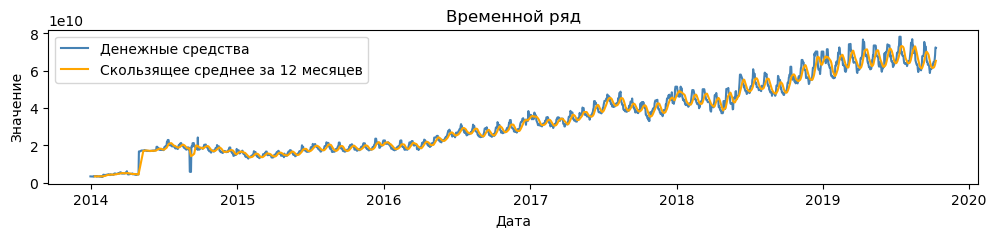

In [13]:
# построим график за весь период
plot_time_series(data, '2013-12-30', '2019-10-10')

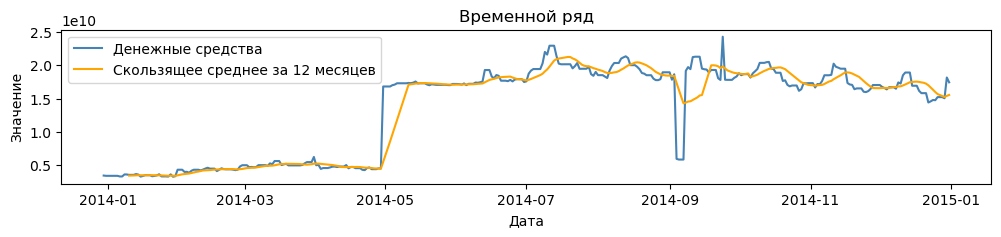

In [14]:
# построим график временного ряда за 2014 год
plot_time_series(data, '2013-12-30', '2014-12-31')

In [15]:
# рассмотрим подробнее момент резкого увеличения денежных средств подробнее
data['2014-04-27':'2014-05-02']

,VALUE
REPORTDATE,
2014-04-27,4416849426
2014-04-28,4531256049
2014-04-29,4523887116
2014-04-30,16828540812
2014-05-01,16828540812
2014-05-02,16828540812


Как мы можем наблюдать, с 29.04.2014 г. по 30.04.2014 г. __количество денежных средств увеличилось в 4 раза__. Ниже на картинке из презентации Сбербанка для инвесторов подготовленной в 2015 году на основании финансовой отчетности по стандартам МСФО за 2014 год, мы видим, что никакого увелиничения на 400% нет. Однако объем денежных средств после 30.04.2014 года более не снижался и имеет тренд на увеличение. Соответственно, можно прийти к выводу, что данные до 30.04.2014 г. являются аномальными, а значит их не стоит брать для последующего обучения модели.

![picture_of_report](Screenshot_1.jpg)

In [16]:
# рассмотрим подробнее момент пробития денежных средств подробнее
data['2014-09-02':'2014-09-09']

,VALUE
REPORTDATE,
2014-09-02,17842438513
2014-09-03,18664454550
2014-09-04,5966423157
2014-09-05,5860195697
2014-09-06,5860195697
2014-09-07,5860195697
2014-09-08,19175854331
2014-09-09,19739611315


Как мы можем наблюдать, в период с 03.05.2014 г. по 08.09.2014 г. __количество денежных средств уменьшалось чуть меньше чем в 4 раза и вернулось к прежнему состоянию__. Соответственно, можно прийти к выводу, что данные с 04.05.2014 г. по 07.09.2014 г. являются аномальными, а значит их не стоит брать для последующего обучения модели.

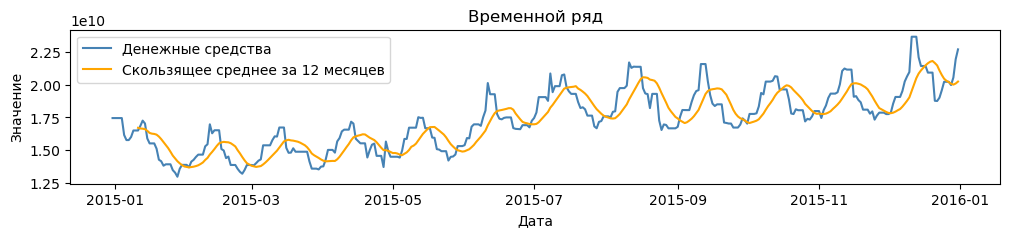

In [17]:
# построим график временного ряда за 2015 год
plot_time_series(data, '2014-12-31', '2015-12-31')

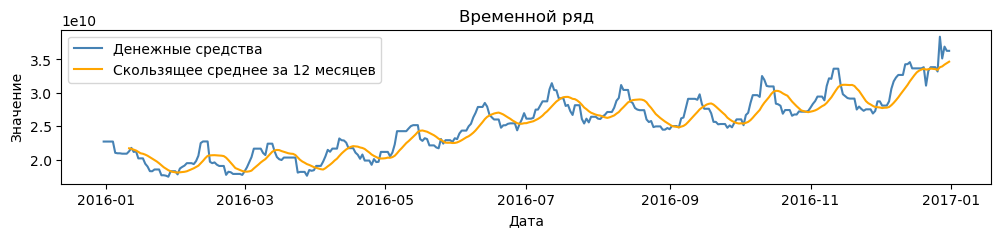

In [18]:
# построим график временного ряда за 2016 год
plot_time_series(data, '2015-12-31', '2016-12-31')

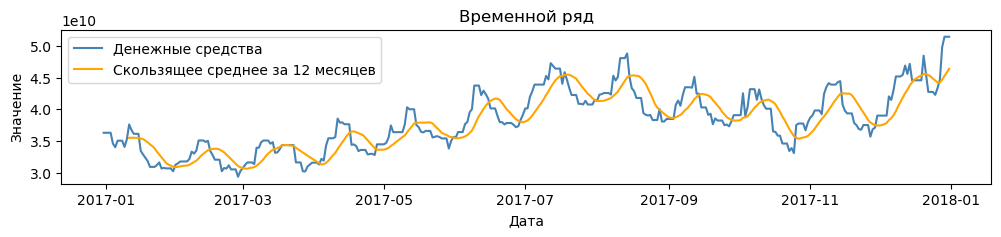

In [19]:
# построим график временного ряда за 2017 год
plot_time_series(data, '2016-12-31', '2017-12-31')

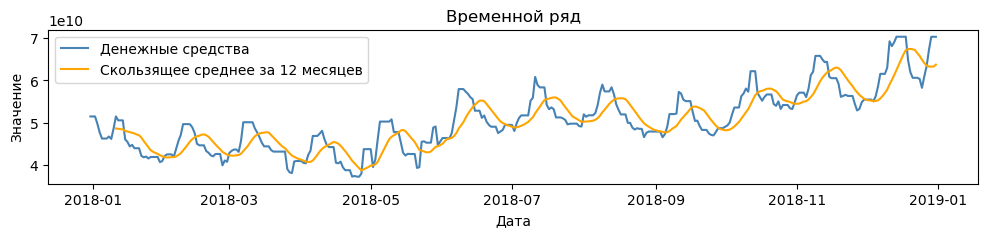

In [20]:
# построим график временного ряда за 2018 год
plot_time_series(data, '2017-12-31', '2018-12-31')

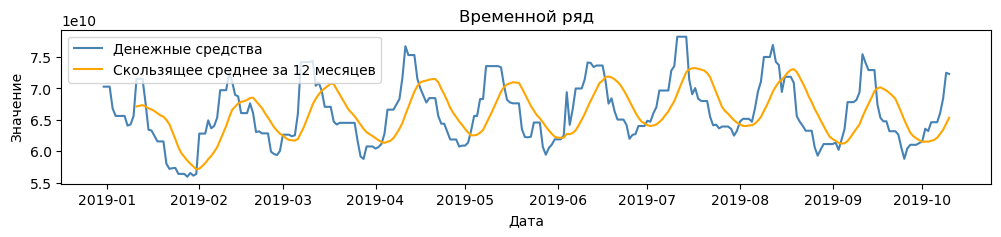

In [21]:
# построим график временного ряда за 2019 год
plot_time_series(data, '2018-12-31', '2019-10-10')

По результатам изучения остальных годовых периодов аномалий не наблюдается. Отчетливо наблюдаем закономерность роста и падения в течении месяца при сохранении годового тренда

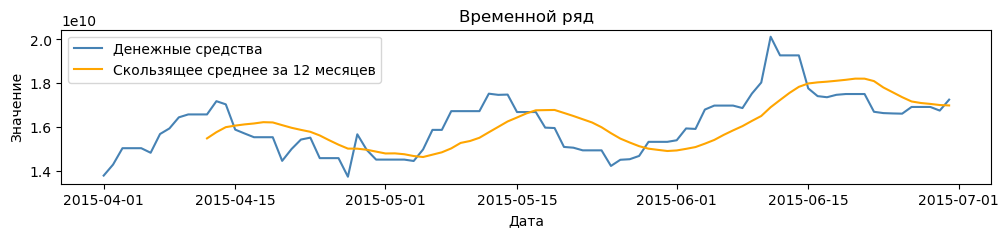

In [22]:
# построим график временного ряда за 2 квартал 2015 года
plot_time_series(data, '2015-04-01', '2015-06-30')

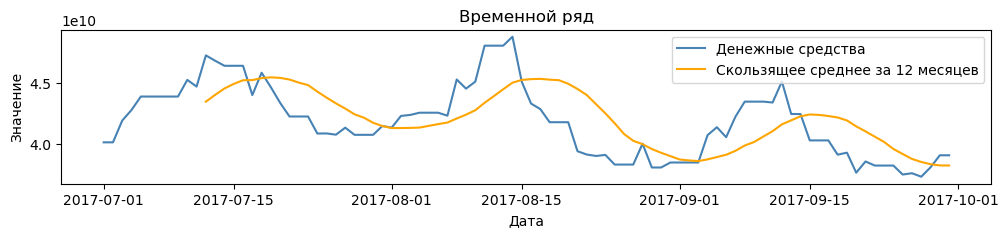

In [23]:
# построим график временного ряда за 3 квартал 2017 года
plot_time_series(data, '2017-07-01', '2017-09-30')

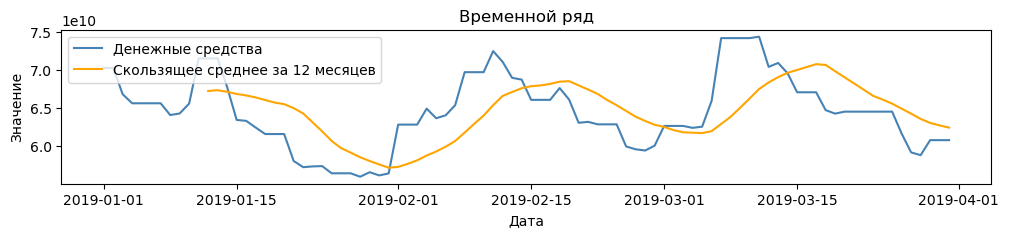

In [24]:
# построим график временного ряда за 1 квартал 2019 года
plot_time_series(data, '2019-01-01', '2019-03-31')

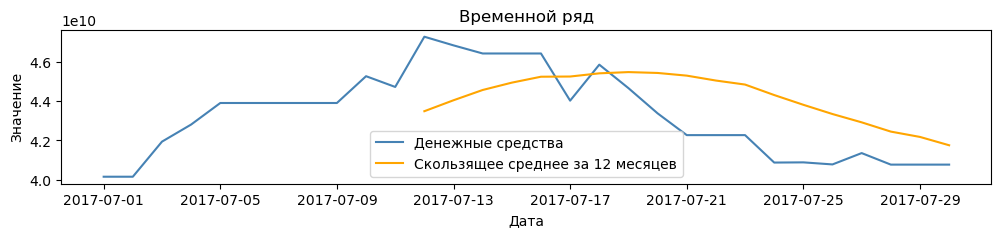

In [25]:
# построим график временного ряда за июнь 2017 года
plot_time_series(data, '2017-07-01', '2017-07-30')

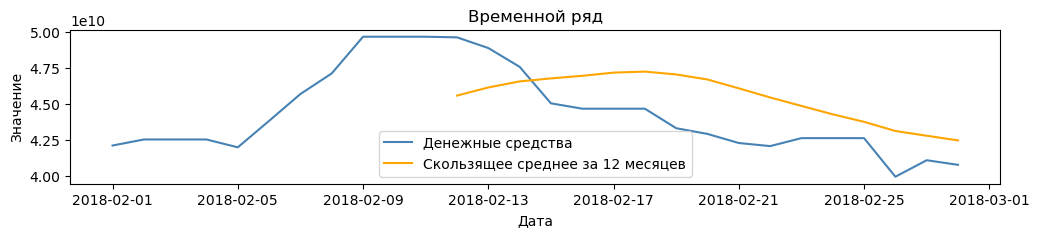

In [26]:
# построим график временного ряда за февраль 2018 года
plot_time_series(data, '2018-02-01', '2018-02-28')

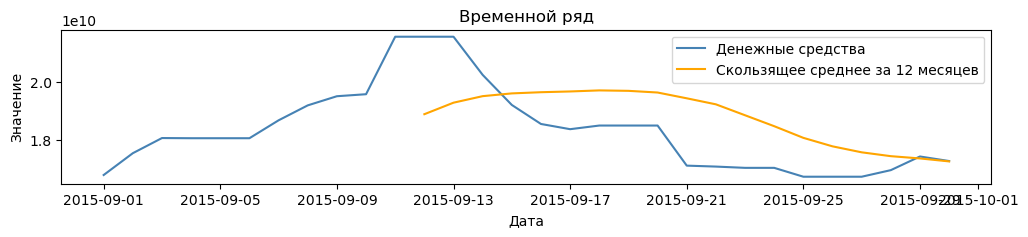

In [27]:
# построим график временного ряда за сентябрь 2015 года
plot_time_series(data, '2015-09-01', '2015-09-30')

На данных графиках отчетливо прослеживается следующая зависимость: макисмально накопление денежных средств происходит в середине месяца, далее идет снижение количество денежных средств и достигает минимума к концу месяца. Далее начинается рост накопления


### __Разложение временного ряда на компоненты__

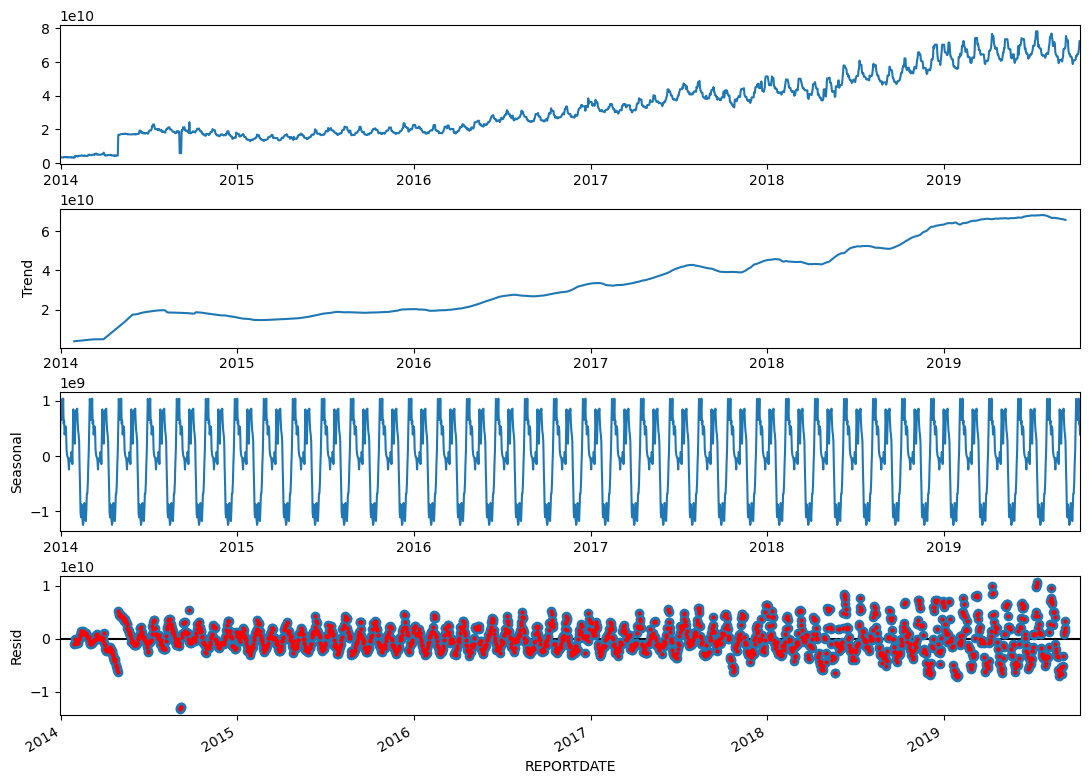

In [32]:
# задаем размер графика
rcParams['figure.figsize'] = 11, 9

# применяем функцию к данным
decompose = seasonal_decompose(data, model='additive', period=60)
decompose.plot()

# Устанавливаем размер точек на графике выбросов
decompose.resid.plot(marker='o', linestyle='', color='r', markersize=2)

# Отображение графика
plt.show()

### __Проверка на стационарность__

Стационарность процесса можно оценить визуально. Датасет демонстрирует очевидный тренд и сезонность. Но для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test). Используем пороговое значение, равное 0,05 (5%)

In [29]:
# передадим ей столбец с данными о перевозках и поместим результат в adf_test
adf_test = adfuller(data['VALUE'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.9349887607019645


Явное превышение порога в 0,05. Что собственно и подтверждает визуальное наблюдение

### __Автокорреляция__

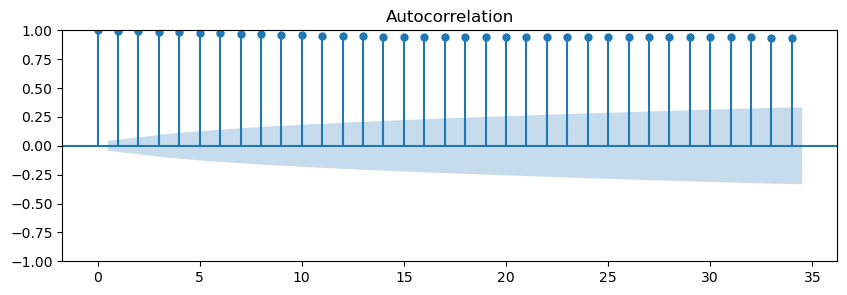

In [30]:
# Создаем новый объект Figure и Axes
fig, ax = plt.subplots(figsize=(10, 3))

# Применяем функцию к данным о размере денежных средств
plot_acf(data, ax=ax)

# Отображение графика
plt.show()

Корреляция постоянно положительная говорит о наличии тренда. Все это согласуется с тем, что узнали о данных, когда раскладывали их на компоненты. Синяя граница позволяет оценить статистическую значимость корреляции. Если столбец выходит за ее пределы, то автокорреляция достаточно сильна и ее можно использовать при построении модели

In [31]:
# убрать выбросы 2014 года 

# __Подбор модели обучения__


### __ARIMA (Autoregressive Integrated Moving Average)__